In [1]:
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import h5py
import pandas, numpy, random
import matplotlib.pyplot as plt

In [3]:
if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda: Tesla K80


device(type='cuda')

In [4]:
def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data

def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

In [5]:
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

In [6]:
def crop_centre(img, new_width, new_height):
    height, width, _ = img.shape
    startx = width//2 - new_width//2
    starty = height//2 - new_height//2    
    return img[  starty:starty + new_height, startx:startx + new_width, :]

In [7]:
class CelebADataset(Dataset):
    
    def __init__(self, file):
        self.file_object = h5py.File(file, 'r')
        self.dataset = self.file_object['img_align_celeba']
        pass
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        if (index >= len(self.dataset)):
          raise IndexError()
        img = numpy.array(self.dataset[str(index)+'.jpg'])
        img = crop_centre(img, 128, 128)
        return torch.cuda.FloatTensor(img).permute(2,0,1).view(1,3,128,128) / 255.0
    
    def plot_image(self, index):
        img = numpy.array(self.dataset[str(index)+'.jpg'])
        img = crop_centre(img, 128, 128)
        plt.imshow(img, interpolation='nearest')
        pass
    
    pass

In [8]:
celeba_dataset = CelebADataset('mount/My Drive/Colab Notebooks/data_gan/celeba_dataset/celeba_aligned_small.h5py')

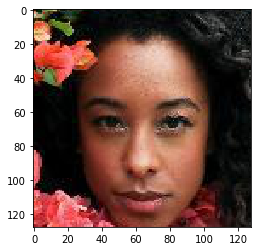

In [9]:
celeba_dataset.plot_image(43)

In [10]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.GELU(),
            
            nn.Conv2d(256, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.GELU(),
            
            nn.Conv2d(256, 3, kernel_size=8, stride=2),
            nn.GELU(),
            
            View(3*10*10),
            nn.Linear(3*10*10, 1),
            nn.Sigmoid()
        )
        
        self.loss_function = nn.BCELoss()

        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        outputs = self.forward(inputs)
        loss = self.loss_function(outputs, targets)
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 1000 == 0):
            print("counter = ", self.counter)
            pass

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [11]:
%%time

D = Discriminator()
D.to(device)

for image_data_tensor in celeba_dataset:
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    D.train(generate_random_image((1,3,128,128)), torch.cuda.FloatTensor([0.0]))
    pass

counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
CPU times: user 14min 48s, sys: 7.88 s, total: 14min 56s
Wall time: 15min 39s


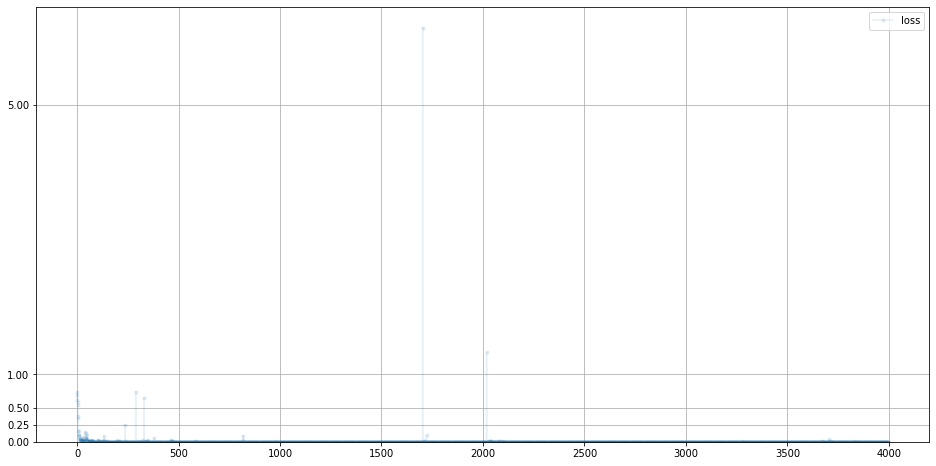

In [12]:
D.plot_progress()

In [13]:
for i in range(4):
  image_data_tensor = celeba_dataset[random.randint(0,20000)]
  print( D.forward( image_data_tensor ).item() )
  pass

for i in range(4):
  print( D.forward( generate_random_image((1,3,128,128))).item() )
  pass

1.0
1.0
1.0
1.0
4.811351118405582e-06
3.0192164558684453e-05
7.897709292592481e-05
7.579883458674885e-07


In [14]:
class Generator(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(100, 3*11*11),
            nn.GELU(),
            
            View((1, 3, 11, 11)),
            
            nn.ConvTranspose2d(3, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.GELU(),

            nn.ConvTranspose2d(256, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.GELU(),

            nn.ConvTranspose2d(256, 3, kernel_size=8, stride=2, padding=1),
            nn.BatchNorm2d(3),
            nn.Sigmoid()
        )
        
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        self.counter = 0;
        self.progress = []
        
        pass
    
    
    def forward(self, inputs):        
        return self.model(inputs)
    
    
    def train(self, D, inputs, targets):
        g_output = self.forward(inputs)
        d_output = D.forward(g_output)

        loss = D.loss_function(d_output, targets)

        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

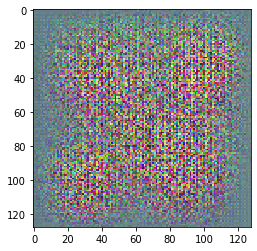

In [15]:
G = Generator()
G.to(device)

output = G.forward(generate_random_seed(100))

img = output.detach().permute(0,2,3,1).view(128,128,3).cpu().numpy()

plt.imshow(img, interpolation='none', cmap='Blues')

In [16]:
D = Discriminator()
G = Generator()
D.to(device)
G.to(device)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=363, bias=True)
    (1): GELU()
    (2): View()
    (3): ConvTranspose2d(3, 256, kernel_size=(8, 8), stride=(2, 2))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): GELU()
    (6): ConvTranspose2d(256, 256, kernel_size=(8, 8), stride=(2, 2))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): GELU()
    (9): ConvTranspose2d(256, 3, kernel_size=(8, 8), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Sigmoid()
  )
)

In [17]:
%%time 

epochs = 2

for epoch in range(epochs):
  print ("epoch = ", epoch + 1)

  for image_data_tensor in celeba_dataset:
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    D.train(G.forward(generate_random_seed(100)).detach(), torch.cuda.FloatTensor([0.0]))
    G.train(D, generate_random_seed(100), torch.cuda.FloatTensor([1.0]))
    pass
  pass

epoch =  1
counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
epoch =  2
counter =  41000
counter =  42000
counter =  43000
counter =  44000
counter =  45000
counter =  46000
counter =  47000
counter =  48000
counter =  49000
counter =  50000
counter =  51000
counter =  52000
counter =  53000
counter =  54000
counter =  55000
counter =  56000
counter =  57000
counter =  58000
c

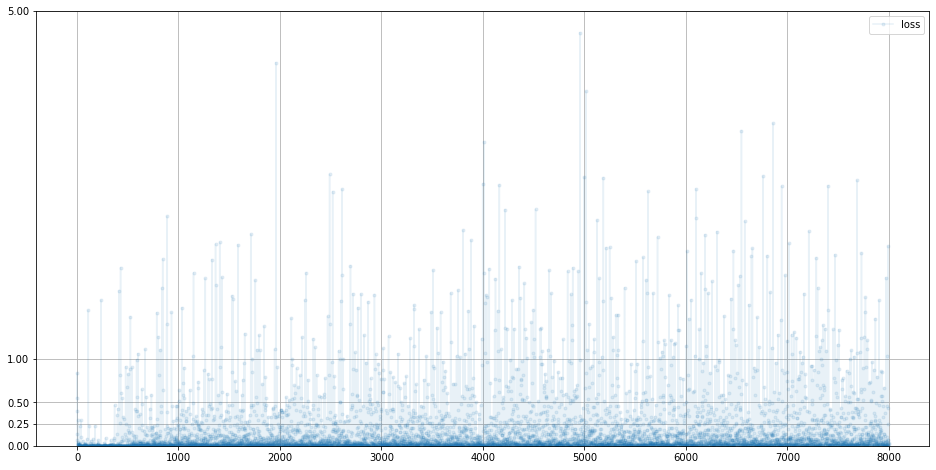

In [18]:
D.plot_progress()

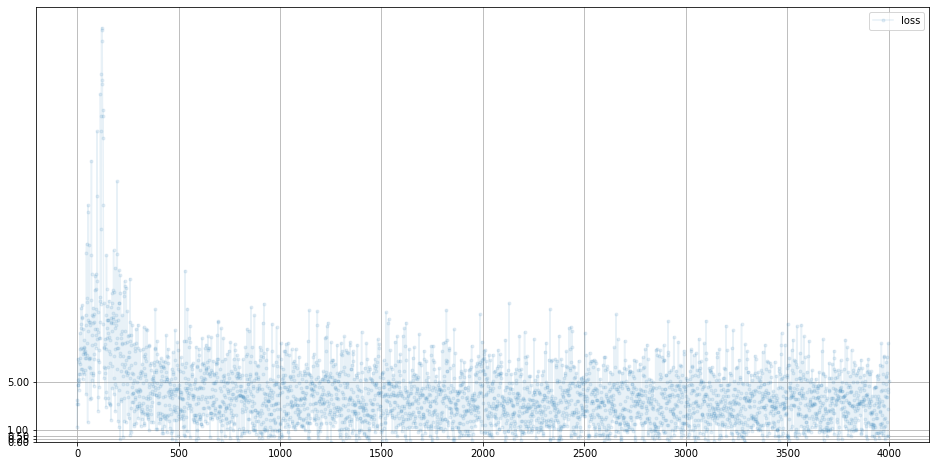

In [19]:
G.plot_progress()

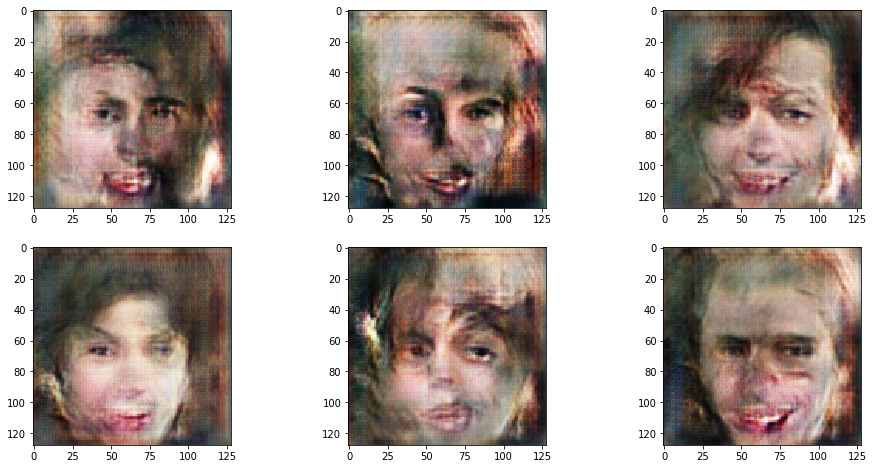

In [20]:
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        img = output.detach().permute(0,2,3,1).view(128,128,3).cpu().numpy()
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        pass
    pass

In [21]:
torch.cuda.memory_allocated(device) / (1024*1024*1024)

0.1442699432373047

In [22]:
torch.cuda.max_memory_allocated(device) / (1024*1024*1024)

0.20594406127929688